In [62]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Loading data
data = pd.read_csv("../data/cleaned_data.csv")

# Converting date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Ignoring the UserWarning raised by the above line. The warning raised tells me that not setting a specific format or handing errors could be problematic, but further
# examination of the Date column showed that it is not, so I am hiding the warning from printing
warnings.simplefilter(action = "ignore", category = UserWarning)
data.head(2)

,Date,About,Period,Player Load Per Minute,IMA Accel Low,IMA Accel High,IMA Accel Total,IMA Jump Count Low Band,IMA Jump Count Med Band,IMA Jump Count High Band,Season,Prop_Accel_High,Prop_Jump_High
0,2022-11-07,Athlete A,Game,9.5,21,4,36,16,6,9,1,0.111111,0.290323
1,2022-11-07,Athlete C,Game,8.4,20,3,32,29,14,6,1,0.093750,0.122449


In [64]:
# This code chunk retrieves the n-game (5-game) rolling average of points, assists and rebounds for each player

# Empty list to hold rolling_averages data
rolling_averages = []

# Variable for number of games in rolling average
window = 7

# Looping through each group of the df, where the groups are by player
for player, group in data.groupby("About"):
    # Ensuring the gamedates are in the correct order for the rolling average calculation
    group = group.sort_values(by = "Date")

    # Calculating the rolling average of points/assists/rebounds, over window games, and assigning that to the new column made for that value
    group["Prop_Accel_High"] = group["Prop_Accel_High"].rolling(window, min_periods = 1).mean()
    group["Prop_Jump_High"]= group["Prop_Jump_High"].rolling(window, min_periods = 1).mean()

    # Appending the group to the list of groups to be put in a df later
    rolling_averages.append(group)

# Concatenating the rolling average groups. Each player/group is essentially a row in this new dataframe
rolling_df = pd.concat(rolling_averages)

# Filtering out players who have played less than 5 games, as their rolling averages would not make much sense

# Getting game count by player
player_games = rolling_df["About"].value_counts()
# Getting the players who have played more than 5 games
players_met_min_games = player_games[player_games >= 20].index
# Limiting rolling_df to only players in the list of players who have played 5 games
rolling_df = rolling_df[rolling_df["About"].isin(players_met_min_games)]
print(len(rolling_df["About"].unique()))

14


In [73]:
players_seasons = rolling_df.groupby('About')['Season'].nunique()
players_in_both = players_seasons[players_seasons > 1].index.tolist()

print(players_in_both)

['Athlete B', 'Athlete C', 'Athlete E', 'Athlete F']


In [84]:
all_players = rolling_df['About'].unique()

# Create palette
palette = {player: ('navy' if player in players_in_both else 'orange') for player in all_players}

print(palette)

{'Athlete B': 'navy', 'Athlete C': 'navy', 'Athlete D': 'orange', 'Athlete E': 'navy', 'Athlete F': 'navy', 'Athlete G': 'orange', 'Athlete H': 'orange', 'Athlete J': 'orange', 'Athlete M': 'orange', 'Athlete O': 'orange', 'Athlete P': 'orange', 'Athlete Q': 'orange', 'Athlete R': 'orange', 'Ben Vander Plas': 'orange'}


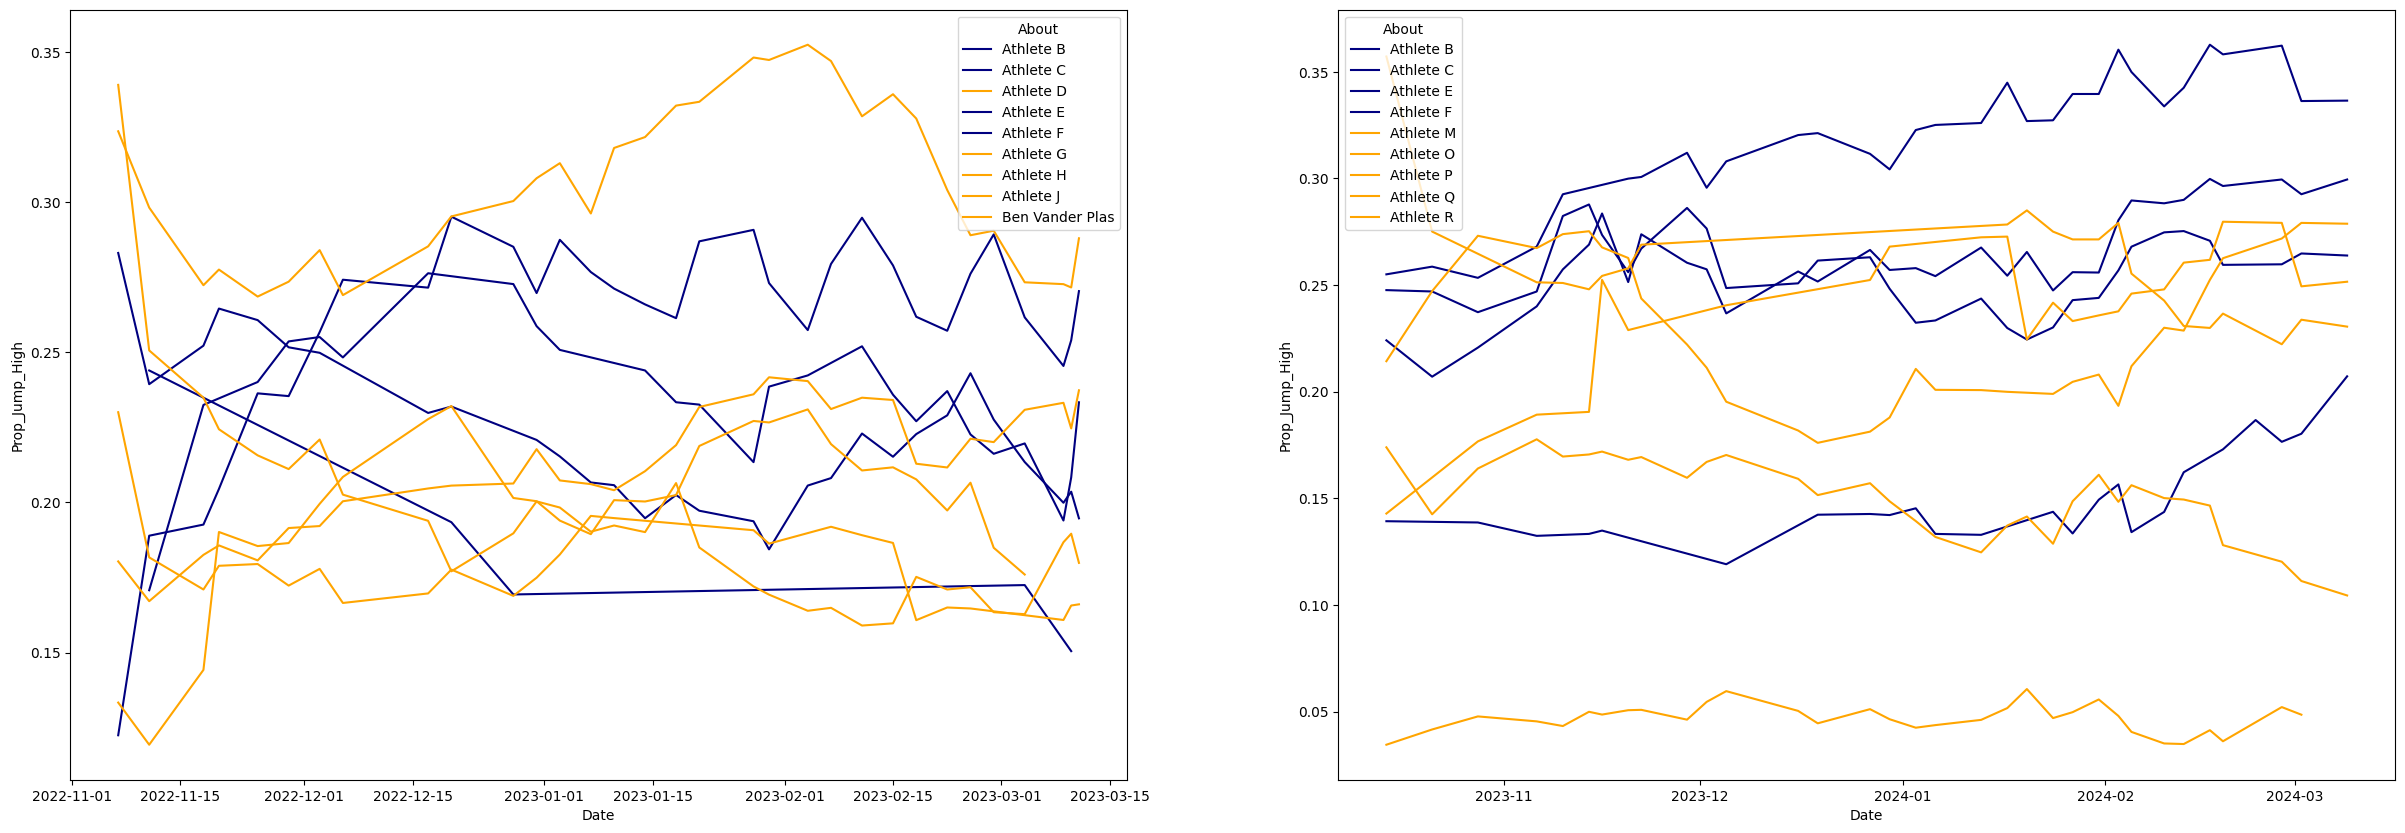

In [85]:
fig, axs = plt.subplots(1, 2, figsize = (30, 10))
axs = axs.flatten()

for ax, season in zip(axs, [1, 2]):
    sns.lineplot(data = rolling_df[rolling_df["Season"] == season], x = 'Date', y = "Prop_Jump_High", hue = "About", palette = palette, ax = ax)
plt.show()